Installation des packages

In [1]:
# 2 min
#!pip install -q -q -q tifffile
#!pip install -q -q -q tqdm # progresbar
#!pip3 install -q -q -q torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
# https://pytorch.org/get-started/locally/#mac-anaconda
# Bien surveiller les versions de torch et prendre la nigthly si besoin ! là j'ai pris la dernière :)
#!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu116 -q -q -q
!pip install py7zr  -q -q -q 
!pip3 install opencv-python -q -q -q 
!pip install matplotlib
#!pip install imageio  -q -q -q 

On installe les dépendances nécessaires à Open cv cf https://stackoverflow.com/questions/55313610/importerror-libgl-so-1-cannot-open-shared-object-file-no-such-file-or-directo :
Dans le terminal !

sudo apt-get update
sudo apt-get install ffmpeg libsm6 libxext6  -y 

In [2]:
import s3fs
from pathlib import Path
import py7zr
import numpy as np
import cv2 as cv2
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


Récupération des données pleiades

In [3]:
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://minio.lab.sspcloud.fr'})
fs.get('projet-slums-detection/Donnees/Cayenne_200722.7z', 'Cayenne.7z')

In [4]:
with py7zr.SevenZipFile('Cayenne.7z', mode='r') as z:
    z.extractall()

In [10]:

# os.getcwd()
img = mpimg.imread('Cayenne_200722/16bits/ORT_2022072050325085_U22N/ORT_2022072050325085_0352_0541_U22N_16Bits.jp2')
img.shape

(2000, 2000, 4)

- ce sont des images de 2000x2000 pixels à 50 cm le pixel =>1000x1000 m^2 = 1km^2
- On en a 240 Dans le fichier brut or la superficie de Cayenne est égale à 23,6 km^2
- 4 channels RGB Infra
- Le fichier pour Cayenne fait 2 Gigas.. ça va vite..

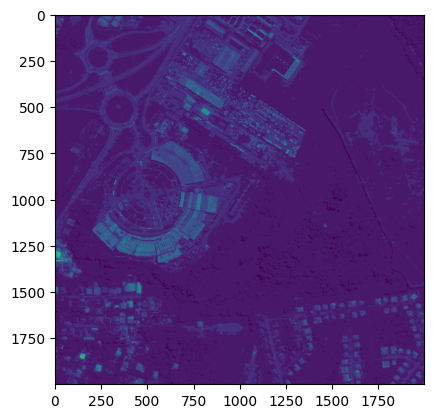

In [17]:
#On voit quelque chose en représentant les channels séparément
plt.imshow(img[:,:,1])
plt.show()

In [23]:
img.copy().shape
img.copy()[:,:,:3].shape
img.copy()[:,:,0].reshape(2000,2000).shape

(2000, 2000)

Normalisation OpenCv

In [22]:
tonemap = cv2.createTonemap()
tonemapped_img = tonemap.process(img.copy()[:,:,0].reshape(2000,2000))
img_8bit = numpy.clip(tonemapped_img*255, 0, 255).astype('uint8')

error: OpenCV(4.6.0) /io/opencv/modules/photo/src/tonemap.cpp:69: error: (-215:Assertion failed) _src.dims() == 2 && _src.type() == CV_32FC3 in function 'process'


A suivre..
récupérer le RIL GUYANE et les opoints associés



## Comment installer gdal...
GDAL vaut pour Geospatial analysis library et permet demodifier simplement des ensembles d'images raster ciontenus dans un même sous dossier

https://mothergeo-py.readthedocs.io/en/latest/development/how-to/gdal-ubuntu-pkg.html
Dans le terminal ! :

- sudo add-apt-repository ppa:ubuntugis/ppa && sudo apt-get update
- sudo apt-get update
- sudo apt-get install gdal-bin
- sudo apt-get install libgdal-dev
- export CPLUS_INCLUDE_PATH=/usr/include/gdal
- export C_INCLUDE_PATH=/usr/include/gdal
- pip install GDAL==3.0.4

Puis on obtent l'erreur 2to3 invalid corrigeable via ce lien :
https://bobbyhadz.com/blog/python-error-in-package-setup-command-use-2to3-is-invalid
- pip install "setuptools<58.0"
- pip3 install "setuptools<58.0"
- python -m pip install "setuptools<58.0"
- python3 -m pip install "setuptools<58.0"
- py -m pip install "setuptools<58.0"


Et enfin !!!

-pip install GDAL==3.0.4

Enfin le graal tant attendu :

In [34]:
from osgeo import ogr
from osgeo import gdal

Maintenant On va créer un raster virtuel à partir d'un dossier d'image en python, c'est l'analogue de la commande de Philippe :

/*création d'un raster virtuel affichable dans Qgis à partir des fichiers jp2 obtenus : image en 16 bits avec 4 bandes et pixel 50 cm*/
gdalbuildvrt Cayenne_2022.vrt ./16bits/ORT_2022072050325085_U22N/*.jp2



In [48]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = [im_dir+l for l in liste]

In [50]:
vrt_options = gdal.BuildVRTOptions(resampleAlg='cubic', addAlpha=True)
my_vrt = gdal.BuildVRT('Cayenne.vrt',list_path_image, options=vrt_options)
my_vrt = None

## Rasterio 
Ok un package est déjà copnstruit par dessus gdal pour gérer les raster, rasterio package 
https://geohackweek.github.io/raster/04-workingwithrasters/

In [54]:
!pip install rasterio # marche, est-ce dépendant des istallations précédentes ?

In [77]:
import rasterio
import rasterio.plot as rp
#import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
im_dir = "Cayenne_200722/16bits/ORT_2022072050325085_U22N/"
liste  = os.listdir(im_dir)
list_path_image = [im_dir+l for l in liste]

len(liste)
liste

In [113]:

## caractéristique d'une image
filepath = list_path_image[200]
with rasterio.open(filepath) as src:
    print(src.profile)

{'driver': 'JP2OpenJPEG', 'dtype': 'uint16', 'nodata': None, 'width': 2000, 'height': 2000, 'count': 4, 'crs': CRS.from_epsg(2972), 'transform': Affine(0.5, 0.0, 353000.0,
       0.0, -0.5, 545000.0), 'blockxsize': 1024, 'blockysize': 1024, 'tiled': True, 'interleave': 'pixel'}


[2, 4, 8, 16]


Text(0, 0.5, 'Pixels Lignes')

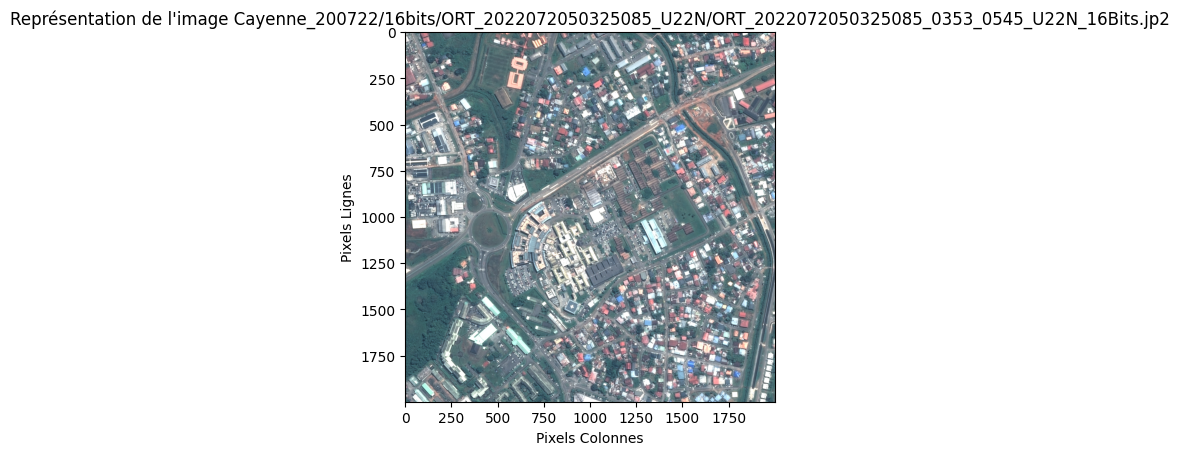

In [117]:
# The grid of raster values can be accessed as a numpy array and plotted:
with rasterio.open(filepath) as src:
   oviews = src.overviews(1) # list of overviews from biggest to smallest
   print(oviews)
   oview = 1 # let's look at the smallest thumbnail
    
   # NOTE this is using a 'decimated read' (http://rasterio.readthedocs.io/en/latest/topics/resampling.html)
   B1 = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
   B2 = src.read(2, out_shape=(1, int(src.height // oview), int(src.width // oview)))
   B3 = src.read(3, out_shape=(1, int(src.height // oview), int(src.width // oview)))

   B1a = rp.adjust_band(np.clip(B1,0,np.quantile(B1,0.95))) # normalisation min-max simple nécessite un clip d'abord étant donné les valeurs extremes
   B2a = rp.adjust_band(np.clip(B2,0,np.quantile(B2,0.95)))
   B3a = rp.adjust_band(np.clip(B3,0,np.quantile(B3,0.95)))
   
   rgb = np.dstack((B1a,B2a,B3a))
   
# Visualize RGB
plt.imshow(rgb)
plt.title("Représentation de l'image {}".format(filepath))
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')